# Практическая работа 1

## Импортируем библиотеки

In [3]:
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch
from torch import nn
from torch import optim

In [4]:
import math

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

## Функции

Используем функции из статьи

In [5]:
def gradient(outputs, inputs, grad_outputs=None, retain_graph=None, create_graph=False):
    '''
    Compute the gradient of `outputs` with respect to `inputs`
    gradient(x.sum(), x)
    gradient((x * y).sum(), [x, y])
    '''
    if torch.is_tensor(inputs):
        inputs = [inputs]
    else:
        inputs = list(inputs)
    grads = torch.autograd.grad(outputs, inputs, grad_outputs,
                                allow_unused=True,
                                retain_graph=retain_graph,
                                create_graph=create_graph)
    grads = [x if x is not None else torch.zeros_like(y) for x, y in zip(grads, inputs)]
    return torch.cat([x.contiguous().view(-1) for x in grads])






In [6]:
def jacobian(outputs, inputs, create_graph=False):
    '''
    Compute the Jacobian of `outputs` with respect to `inputs`
    jacobian(x, x)
    jacobian(x * y, [x, y])
    jacobian([x * y, x.sqrt()], [x, y])
    '''
    if torch.is_tensor(outputs):
        outputs = [outputs]
    else:
        outputs = list(outputs)

    if torch.is_tensor(inputs):
        inputs = [inputs]
    else:
        inputs = list(inputs)

    jac = []
    for output in outputs:
        output_flat = output.view(-1)
        output_grad = torch.zeros_like(output_flat)
        for i in range(len(output_flat)):
            output_grad[i] = 1
            jac += [gradient(output_flat, inputs, output_grad, True, create_graph)]
            output_grad[i] = 0
    return torch.stack(jac)

In [7]:
def hessian(output, inputs, out=None, allow_unused=False, create_graph=False):
    '''
    Compute the Hessian of `output` with respect to `inputs`
    hessian((x * y).sum(), [x, y])
    '''
    assert output.ndimension() == 0

    if torch.is_tensor(inputs):
        inputs = [inputs]
    else:
        inputs = list(inputs)

    n = sum(p.numel() for p in inputs)
    if out is None:
        out = output.new_zeros(n, n)

    ai = 0
    for i, inp in enumerate(inputs):
        [grad] = torch.autograd.grad(output, inp, create_graph=True, allow_unused=allow_unused)
        grad = torch.zeros_like(inp) if grad is None else grad
        grad = grad.contiguous().view(-1)

        for j in range(inp.numel()):
            if grad[j].requires_grad:
                row = gradient(grad[j], inputs[i:], retain_graph=True, create_graph=create_graph)[j:]
            else:
                row = grad[j].new_zeros(sum(x.numel() for x in inputs[i:]) - j)

            out[ai, ai:].add_(row.type_as(out))  # ai's row
            if ai + 1 < n:
                out[ai + 1:, ai].add_(row[1:].type_as(out))  # ai's column
            del row
            ai += 1
        del grad

    return out

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Архитектура

Создадим три нейросети с одним внутренним слоем, с двумя и с тремя.

In [9]:
class Neural_model(nn.Module):
    def __init__(self, input_dim=10, hidden_dim=3, output_dim=1, hidden_layers = 1 ,device='cpu'):
        
        super(Neural_model, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.hidden_layers = hidden_layers
        self.output_dim = output_dim
        self.device = device
        
        """
        Сделаем список модулей
        """
        list_of_layers = []
        list_of_layers.append(nn.Linear(self.input_dim, self.hidden_dim))
        list_of_layers.append(nn.ReLU())
        for i in range(hidden_layers - 1):
            list_of_layers.append(nn.Linear(self.hidden_dim,self.hidden_dim))
            list_of_layers.append(nn.ReLU())
        
        self.network = nn.Sequential(*list_of_layers)
            
        self.output = nn.Linear(self.hidden_dim, self.output_dim) 
        
        params = []
        for param in self.parameters():
            params.append(param.data.view(-1))
        self.D = len(torch.cat(params).view(-1))
        self.S = torch.Tensor([0.5*1*(1+math.log(2*math.pi))]).mean().to(device)

        self.to(device)
        
    def predict(self, input):
        x = input
        return self.output(self.network(x))

        
    def log_prior_w(self, w):
        w = w.view(-1)
        return -0.5*torch.dot(w, w)-0.5*len(w)*math.log(2*math.pi)
      
    def log_priot_all(self):
        T = 0
        for w in self.parameters():
            T += self.log_prior_w(w)
        return T
     
    def loglikelihood(self, batch_x, batch_y):
        D = len(batch_y)
        return -0.5*torch.sum((self.predict(batch_x) - batch_y)**2)- 0.5*D*math.log(2*math.pi)
    
    def margin_log_likelihood(self, batch_x, batch_y):
        T = self.log_priot_all() + self.loglikelihood(batch_x, batch_y)
        return T/len(batch_y)
    
    def loss(self, batch_x, batch_y):
        out = self.predict(batch_x)
        return torch.mean((out - batch_y)**2)

Оптимизируем функцию потерь

In [10]:
def learning(model, X_train, Y_train, X_test, Y_test, alpha = 0.0001, steps = 1000):
    List_of_steps = []
#     Обработка данных
    train_data = TensorDataset(torch.Tensor(X_train).to(device), torch.Tensor(Y_train).to(device))
    test_data = TensorDataset(torch.Tensor(X_test).to(device), torch.Tensor(Y_test).to(device))
    generator = DataLoader(train_data, batch_size=64, shuffle=True)
    test_generator = DataLoader(test_data, batch_size=64, shuffle=True)
    X_ts, Y_ts = test_data[:]
    X_tr, Y_tr = train_data[:]

    for i in tqdm(range(steps)):
        for batch_x, batch_y in generator:
            # подсчет стат величин
            model.zero_grad()
            margin_log_likelihood = -model.margin_log_likelihood(batch_x, batch_y)

            params = []
            for param in model.parameters():
                params.append(param)

            model.S = (model.S+torch.log(torch.det(torch.eye(model.D, device=device) - alpha*hessian(margin_log_likelihood, params)))).detach()

              
            model.zero_grad()
             # оптимизация 
            optimazer = optim.SGD(model.parameters(), lr=alpha)

            loss = model.loss(batch_x, batch_y)
            loss.backward()

            optimazer.step()
        for test_batch_x, test_batch_y in test_generator:
            test_loss = model.loss(test_batch_x, test_batch_y)
        
        List_of_steps.append((model.S.item(), model.log_priot_all().item(), len(Y_tr), model.loglikelihood(X_tr, Y_tr).item(), len(Y_ts), model.loglikelihood(X_ts, Y_ts).item(),test_loss.item()))
        
    return List_of_steps
        


## Эксперименты

### Простая модель

Строим простую модель с одним скрытым слоем, размерности 2

In [15]:
alpha = 0.0001
steps = 1500
m = 256
n = 50
model = Neural_model(input_dim=n, output_dim=1, hidden_layers=1, hidden_dim=2)

"""
генерация данных
"""
w = np.random.randn(n)

X_train = np.random.randn(m, n)
Y_train = (X_train@w + 0.001*np.random.randn(m)).reshape([-1, 1])

X_test = np.random.randn(m, n)
Y_test = (X_test@w+ 0.001*np.random.randn(m)).reshape([-1, 1])

In [16]:
List_of_steps = learning(model, X_train, Y_train, X_test, Y_test, alpha = 0.0001, steps = steps)

In [17]:
len(List_of_steps)

1500

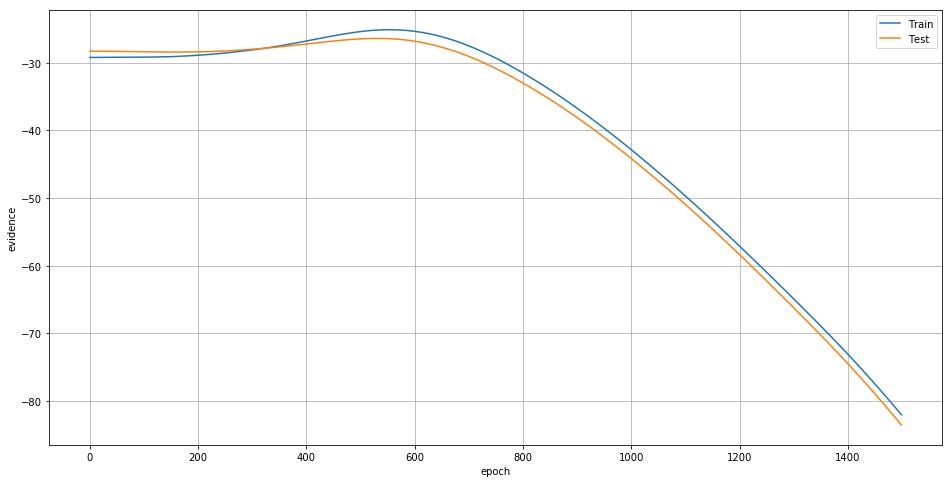

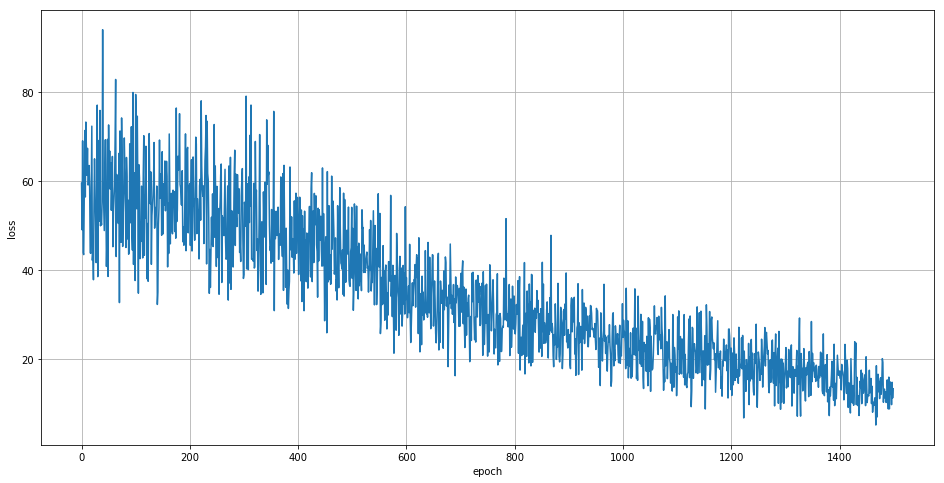

In [18]:
plt.rcParams['figure.figsize'] = (16.0, 8.0)
plt.plot([item[0]+(item[1]+item[3])/item[2] for item in List_of_steps], label = 'Train')
plt.plot([item[0]+(item[1]+item[5])/item[4] for item in List_of_steps], label = 'Test')
plt.xlabel('epoch')
plt.ylabel('evidence')


plt.grid()
plt.legend(loc='best')
plt.show()
plt.rcParams['figure.figsize'] = (16.0, 8.0)
plt.plot([item[-1]for item in List_of_steps])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.show()

Замечаем,что для простой модели до примерно 600 итерации у нас обоснованность растет, что соответсвует обучению модели, а затем резко начинает падать из-за влияния энтропийного члена. Это можно итерпретировать как переобучение. На графике с ошибкой на тесте после 700 итерации скорость обучения немного снизилась, но это сложно распознать из-за шума.

### Средняя модель

Строим простую модель с двумя скрытыми слоями, размерности 2

In [19]:
model = Neural_model(input_dim=n, output_dim=1, hidden_layers=2, hidden_dim=2)
alpha = 0.0001
steps = 1500
m = 256
n = 50

w = np.random.randn(n)

X_train = np.random.randn(m, n)
Y_train = (X_train@w + 0.001*np.random.randn(m)).reshape([-1, 1])

X_test = np.random.randn(m, n)
Y_test = (X_test@w+ 0.001*np.random.randn(m)).reshape([-1, 1])

In [20]:
List_of_steps = learning(model, X_train, Y_train, X_test, Y_test, alpha = 0.0001, steps = steps)

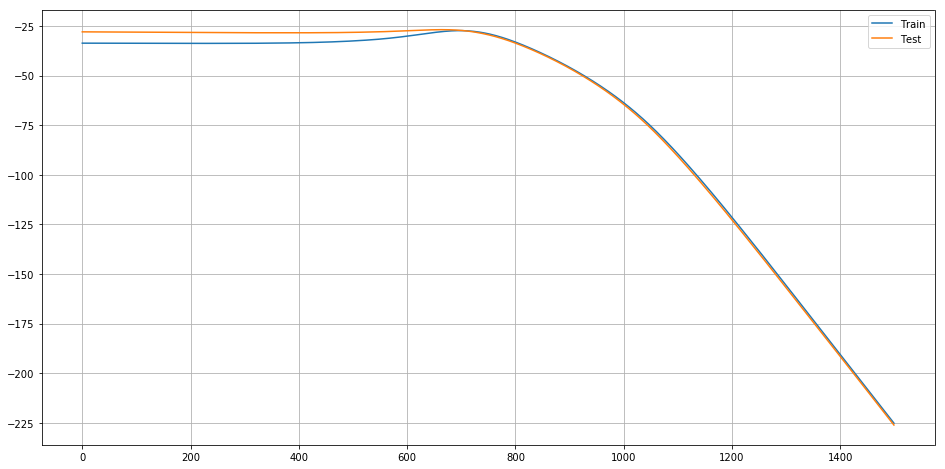

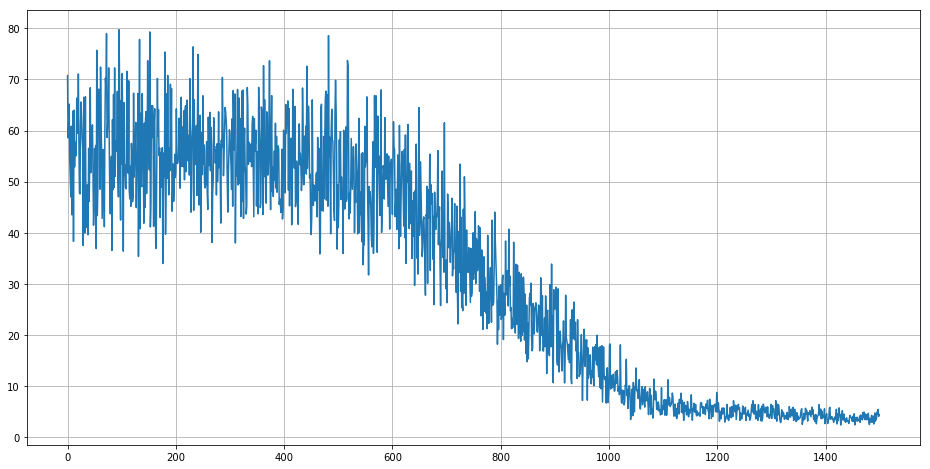

In [21]:
plt.rcParams['figure.figsize'] = (16.0, 8.0)
plt.plot([item[0]+(item[1]+item[3])/item[2] for item in List_of_steps], label = 'Train')
plt.plot([item[0]+(item[1]+item[5])/item[4] for item in List_of_steps], label = 'Test')



plt.grid()
plt.legend(loc='best')
plt.show()
plt.rcParams['figure.figsize'] = (16.0, 8.0)
plt.plot([item[-1]for item in List_of_steps])
plt.grid()
plt.show()

До 700 итерации обусловленность росла но крайне не сильно, что интерпетируется как достаточно обученная модель, а потом обусловленность резко падает, что соотвествует переобучению. Также заметно, что ошибка на тесте также выходит на плато.

### Сложная модель
Строим простую модель с тремя скрытыми слоями, размерности 2

In [27]:
alpha = 0.0001
steps = 1500
m = 256
n = 50
model = Neural_model(input_dim=n, output_dim=1, hidden_layers=3, hidden_dim=2)


w = np.random.randn(n)

X_train = np.random.randn(m, n)
Y_train = (X_train@w + 0.001*np.random.randn(m)).reshape([-1, 1])

X_test = np.random.randn(m, n)
Y_test = (X_test@w+ 0.001*np.random.randn(m)).reshape([-1, 1])

In [28]:
List_of_steps = learning(model, X_train, Y_train, X_test, Y_test, alpha = 0.0001, steps = steps)

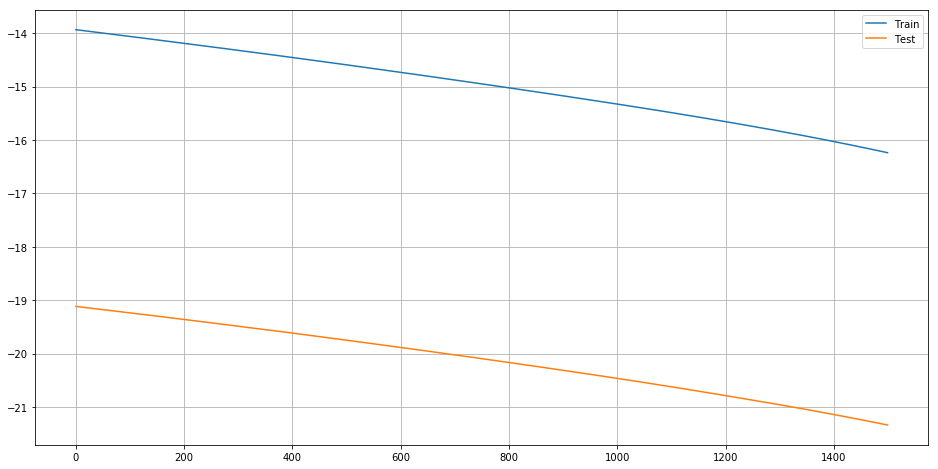

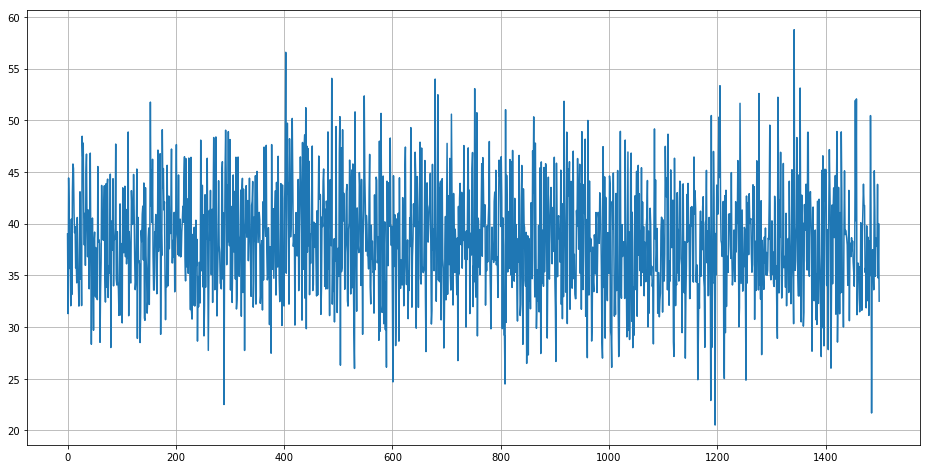

In [29]:
plt.rcParams['figure.figsize'] = (16.0, 8.0)
plt.plot([item[0]+(item[1]+item[3])/item[2] for item in List_of_steps], label = 'Train')
plt.plot([item[0]+(item[1]+item[5])/item[4] for item in List_of_steps], label = 'Test')



plt.grid()
plt.legend(loc='best')
plt.show()
plt.rcParams['figure.figsize'] = (16.0, 8.0)
plt.plot([item[-1]for item in List_of_steps])
plt.grid()
plt.show()

Как можно заметить обоснованность падает сразу, так как структура модели слишком сложная, это сказывается на ошибке на тесте